In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from lightgbm.sklearn import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

from scripts_misc.preprocessing_old import * 
from scripts_misc.PCA_data import *

## Summary

|Model| Comments|
|-----|---------|
| Simple LR | Test $R^2$ = 12.5%|
| Ridge with gridsearch| Test $R^2$ = 12.5%|
| Simple LGBM | Test $R^2$ = 32.5%|
| Simple LGBM dropping repeated counts| Test $R^2$ = 37.3%|
| LGBM with MAE objective funct | Test $R^2$ = 38.6%|
| LGBM with MAE objective funct and scaled X | Test $R^2$ = 39.3%|
| Ridge with log transformed y | Test $R^2$ = 47.1%|
| LGBM with log transformed y | Test $R^2$ = 73.1%|


**Comments -** 
> - LGBM can be good model with feature selection
> - log transforming y can be an approach given the interpretability issue.
> - Quantile regression will be looked into


In [2]:
df = pd.read_csv("../data/old_train_data.zip")

In [3]:
df.head()

,external_id,month,year,monthly_number_of_sessions,monthly_unique_sessions,monthly_repeated_sessions,monthly_avg_length_of_session,monthly_avg_light_activity,monthly_avg_moderate_activity,monthly_avg_vigorous_activity,...,avg_wind_9_10,avg_wind_10_11,avg_wind_11_12,avg_wind_12_above,perfect_days,unacast_session_count,hpi,state_and_local_amount_per_capita,state_amount_per_capita,local_amount_per_capita
0,1900203,3,2019,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,78.0,323.61,0.132207,0.018519,0.113688
1,1900203,6,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,111.0,323.61,0.132207,0.018519,0.113688
2,1900203,8,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,110.0,323.61,0.132207,0.018519,0.113688
3,MR00101775,1,2019,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,110.38,0.076247,0.011966,0.064281
4,MR00101775,8,2019,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,110.38,0.076247,0.011966,0.064281


## Function for pre-processing data

In [4]:
clean_df = preprocessing_na(df)
# create X and y
X = clean_df.drop(columns = ['external_id', 'state','climate', 'unacast_session_count'], axis=1)
y = clean_df.loc[:, 'unacast_session_count']
# split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2020)

In [5]:
X_train_valid  = clean_categorical(X_train, X_valid, ['income_class', 'density_class'])
X_train = X_train_valid[0]
X_valid = X_train_valid[1]

In [6]:
def show_scores(model, X, y, show = True):
    """
    Shows R-squared score and mean squared error
    
    Parameters
    ----------
    model: The sklearn model
    X: numpy.ndarray        
        The X part of the data
    y: numpy.ndarray
        The y part of the data
    Returns
    -------
        rmse: (float)
        r2: (float)
            
    """        
        
    y_preds = model.predict(X)                 
    rmse = mean_squared_error(y, y_preds, squared=False)
    r2 = r2_score(y, y_preds)
    if show: 
        print("Root mean squared error: %0.3f and r^2 score: %0.3f" % (rmse,r2))
    return rmse, r2

## Modelling with Linear regression

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Simple linear regression scores: ')
print('Train error: ')
show_scores(lr, X_train, y_train)

print('Test error: ')    
show_scores(lr, X_valid, y_valid)

Simple linear regression scores: 
Train error: 
Root mean squared error: 502.552 and r^2 score: 0.209
Test error: 
Root mean squared error: 335.686 and r^2 score: 0.223


(335.68598615547177, 0.2230641738048189)

### Observations 

- Very poor model with $R^2 = 12.5 \%$

### 2. SVR

### Observations
- Very long train runtime. Not feasible on whole dataset
- Very Poor model with negative $R^2$


### 3. Lasso L1

### Observations
- Same performance as simple LR 

### 4. Ridge L2

In [21]:
ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train, y_train)

print('Test error: ')    
show_scores(ridge_lr, X_valid, y_valid)

C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.82611e-20): result may not be accurate.
  overwrite_a=True).T


Ridge regression scores: 
Train error: 
Root mean squared error: 502.594 and r^2 score: 0.209
Test error: 
Root mean squared error: 335.627 and r^2 score: 0.223


(335.62726523969167, 0.22333596586513305)

### Observations

- Same performance as Simple LR

### 4. ElasticNet L1 and L2 Regression

### Observations

- Same performance as Simple LR
- Too slow

### Step 2: Scaling all columns with MinMaxScaler

### Observations:
- Simple LR - slight improvement from last case
- Lasso performs worse than previous case
- Ridge performs same as w/o scaling
- Elastic net performs worse than all models


### Step 3: Scaling all columns with Normalizer

### Observation
- All model performs worse than the minmax scaler

### Step 4: Scaling all columns with StandardScaler

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_valid)

### Observation
- Standard Scaler works best for all models among other scalers
- Moving on to grid search

In [23]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
print('Simple linear regression scores: ')
print('Train error: ')
show_scores(lr, X_train_scaled, y_train)

print('Test error: ')    
show_scores(lr, X_test_scaled, y_valid)

Simple linear regression scores: 
Train error: 
Root mean squared error: 502.552 and r^2 score: 0.209
Test error: 
Root mean squared error: 55544978702.440 and r^2 score: -21272000521438216.000


(55544978702.44048, -2.1272000521438216e+16)

## Gridsearch will take time

In [24]:
# params = {'alpha' : [0.001, 0.1, 1, 10, 100]}

# ridge_lr = Ridge(max_iter=2000, random_state = 2020)

# clf_ridge = GridSearchCV(ridge_lr, params, cv =5)

# clf_ridge.fit(X_train_scaled, y_train)
# print('Ridge regression scores: ')
# print('Train error: ')
# show_scores(clf_ridge, X_train_scaled, y_train)

# print('Test error: ')
# show_scores(clf_ridge, X_test_scaled, y_valid)

In [25]:
# clf_ridge.best_params_

## LGBM on this data

In [26]:
lgbm = LGBMRegressor(random_state = 2020)

lgbm.fit(X_train, y_train)

print('LGBM scores: ')

print('Train error: ')
show_scores(lgbm, X_train, y_train)

print('Test error: ')
show_scores(lgbm, X_valid, y_valid)

LGBM scores: 
Train error: 
Root mean squared error: 300.547 and r^2 score: 0.717
Test error: 
Root mean squared error: 282.628 and r^2 score: 0.449


(282.62773845917906, 0.4492578792974641)

## performing grid search with LGBM - time taking

In [27]:
# params = {'learning_rate' : [0.01, 0.1, 1, 10, 100], 'max_depth' : [100, 500], 'n_estimators' : [100, 500] }

# lgbm = LGBMRegressor(random_state = 2020)

# clf_lgbm = GridSearchCV(lgbm, params, cv =5)

# clf_lgbm.fit(X_train_scaled, y_train)
# print('LGBM regression scores: ')
# print('Train error: ')
# show_scores(clf_lgbm, X_train_scaled, y_train)

# print('Test error: ')
# show_scores(clf_lgbm, X_test_scaled, y_test)

In [28]:
# clf_lgbm.best_params_

In [29]:
#fitting lgbm with MAE
lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)

lgbm.fit(X_train, y_train)
print('LGBM regression scores: ')
print('Train error: ')
show_scores(lgbm, X_train, y_train)

print('Test error: ')
show_scores(lgbm, X_valid, y_valid)

LGBM regression scores: 
Train error: 
Root mean squared error: 513.632 and r^2 score: 0.174
Test error: 
Root mean squared error: 309.058 and r^2 score: 0.341


(309.05834757735306, 0.34143342858865167)

In [30]:
#fitting lgbm with MAE with scaling
lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)

lgbm.fit(X_train_scaled, y_train)
print('LGBM regression scores: ')
print('Train error: ')
show_scores(lgbm, X_train_scaled, y_train)

print('Test error: ')
show_scores(lgbm, X_test_scaled, y_valid)

LGBM regression scores: 
Train error: 
Root mean squared error: 513.492 and r^2 score: 0.175
Test error: 
Root mean squared error: 309.260 and r^2 score: 0.341


(309.2598220957342, 0.3405745122566435)

## Observation 
 - Model performs worse with MAE

## Log transformation

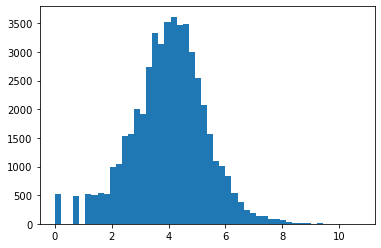

In [31]:
y_log = np.log(y[y>0])

plt.hist(y_log, bins = 50)
plt.show()

## Ridge regression on transformed y

In [34]:

y_train_log = np.log(np.where(y_train==0, 1, y_train))
y_valid_log = np.log(np.where(y_valid==0, 1, y_valid))
       
ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train, y_train_log)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train, y_train_log)

print('Test error: ')    
show_scores(ridge_lr, X_valid, y_valid_log)

C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.82611e-20): result may not be accurate.
  overwrite_a=True).T


Ridge regression scores: 
Train error: 
Root mean squared error: 1.017 and r^2 score: 0.464
Test error: 
Root mean squared error: 1.028 and r^2 score: 0.445


(1.0280184953110723, 0.4448055828345935)

## LGBM on transformed y

In [35]:
lgbm = LGBMRegressor(random_state = 2020)

lgbm.fit(X_train, y_train_log)
print('LGBM regression scores: ')
print('Train error: ')
show_scores(lgbm, X_train, y_train_log)

print('Test error: ')
show_scores(lgbm, X_valid, y_valid_log)

LGBM regression scores: 
Train error: 
Root mean squared error: 0.666 and r^2 score: 0.770
Test error: 
Root mean squared error: 0.706 and r^2 score: 0.738


(0.7055308713925161, 0.7384978420098304)

## Running lgbm with PCA 

In [10]:
X_train_pca = pca_fit_transform(X_train)
X_train_pca.shape

(40080, 459)

In [11]:
X_valid_pca = pca_transform(X_valid)
X_valid_pca.shape

(813, 813)


(10020, 459)

In [13]:

lgbm = LGBMRegressor(random_state = 2020)

lgbm.fit(X_train_pca_parts, y_train)
print('LGBM regression scores: ')
print('Train error: ')
show_scores(lgbm, X_train_pca, y_train)

print('Test error: ')
show_scores(lgbm, X_valid_pca, y_valid)

LGBM regression scores: 
Train error: 
Root mean squared error: 247.393 and r^2 score: 0.808
Test error: 
Root mean squared error: 3382.057 and r^2 score: -77.864


(3382.0567462814083, -77.86430968054553)

In [14]:
ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train_pca, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train_pca, y_train)

print('Test error: ')    
show_scores(ridge_lr, X_valid_pca, y_valid)

Ridge regression scores: 
Train error: 
Root mean squared error: 508.822 and r^2 score: 0.190
Test error: 
Root mean squared error: 72888170.228 and r^2 score: -36629654441.418


(72888170.22820805, -36629654441.41811)